<ipython-input-1-1ea3395de963>:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(input_file, parse_dates=["Timestamp"], infer_datetime_format=True)
<ipython-input-1-1ea3395de963>:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample("1H").agg(np.mean)
<ipython-input-1-1ea3395de963>:16: FutureWarning: The provided callable <function mean at 0x7a5068fd93a0> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_hourly = df.resample("1H").agg(np.mean)


Resampled dataset saved to /content/Merged_Data_sets_2020_2024hours.parquet


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-1-1ea3395de963>:62: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=df['Timestamp'].iloc[-1], periods=len(predicted_values)+1, freq='H')[1:]


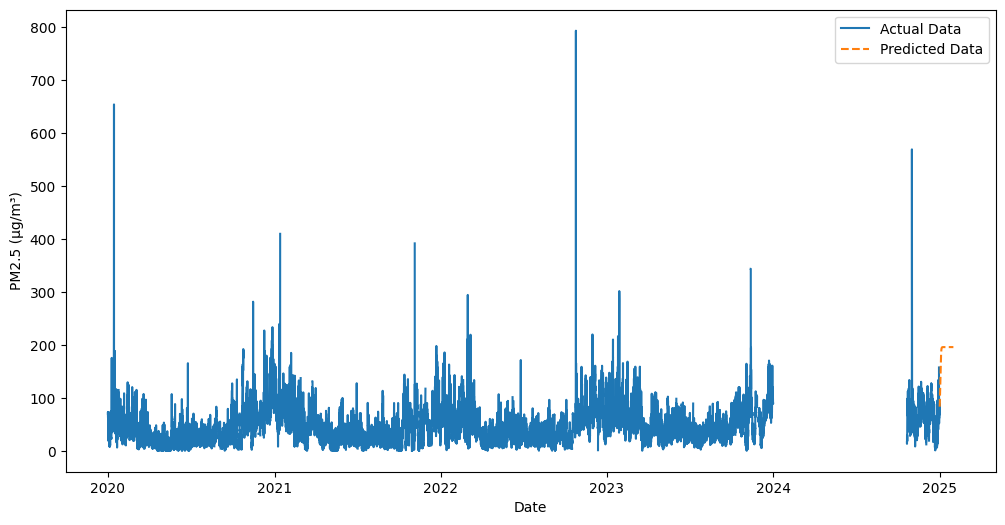

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def resample_to_hourly(input_file, output_file):
    # Load the dataset efficiently
    df = pd.read_csv(input_file, parse_dates=["Timestamp"], infer_datetime_format=True)

    # Set Timestamp as index
    df.set_index("Timestamp", inplace=True)

    # Resample to hourly intervals using optimized aggregation
    df_hourly = df.resample("1H").agg(np.mean)

    # Reset index to keep Timestamp as a column
    df_hourly.reset_index(inplace=True)

    # Save as Parquet for speed optimization
    output_parquet = output_file.replace('.csv', '.parquet')
    df_hourly.to_parquet(output_parquet, index=False)
    print(f"Resampled dataset saved to {output_parquet}")

def prepare_lstm_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

def train_lstm_and_forecast(df, column, n_steps=24, epochs=50):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[column]].dropna())

    X, y = prepare_lstm_data(scaled_data, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)

    predictions = []
    input_seq = scaled_data[-n_steps:].reshape(1, n_steps, 1)
    for _ in range(30 * 24):
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0][0])
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1, 0] = pred[0][0]

    predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predicted_values

def plot_predictions(df, predicted_values, column):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Timestamp'], df[column], label='Actual Data')
    future_dates = pd.date_range(start=df['Timestamp'].iloc[-1], periods=len(predicted_values)+1, freq='H')[1:]
    plt.plot(future_dates, predicted_values, label='Predicted Data', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Example usage
input_file = "/content/Merged_Data_sets_2020_2024.csv"
output_file = "/content/Merged_Data_sets_2020_2024hours.csv"
resample_to_hourly(input_file, output_file)

df_hourly = pd.read_parquet(output_file.replace('.csv', '.parquet'))
df_hourly["Timestamp"] = pd.to_datetime(df_hourly["Timestamp"])
predicted_values = train_lstm_and_forecast(df_hourly, "PM2.5 (µg/m³)")
plot_predictions(df_hourly, predicted_values, "PM2.5 (µg/m³)")





In [ ]:
import pandas as pd
data_merged = pd.read_csv("/content/Merged_Data_sets_2020_2024.csv")
# Display merged dataset
print(data_merged.head())


             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  NO (µg/m³)  NO2 (µg/m³)  \
0  2020-01-01 00:00:00           69.0           NaN         1.6         28.4   
1  2020-01-01 00:15:00           69.0           NaN         2.1         24.7   
2  2020-01-01 00:30:00            NaN           NaN         NaN          NaN   
3  2020-01-01 00:45:00           74.0           NaN         3.2         32.3   
4  2020-01-01 01:00:00           74.0           NaN         2.9         28.7   

   NOx (ppb)  NH3 (µg/m³)  SO2 (µg/m³)  CO (mg/m³)  Ozone (µg/m³)  ...  \
0       16.5         11.5          6.9        1.12           74.9  ...   
1       14.8         11.5          9.2        1.08           71.0  ...   
2        NaN          NaN          NaN         NaN            NaN  ...   
3       19.8          9.7          8.9        1.19           54.3  ...   
4       17.6         11.4          8.8        1.17           57.4  ...   

   MP-Xylene (µg/m³)  AT (°C)  RH (%)  WS (m/s)  WD (deg)  RF (mm)  \
0   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load dataset
file_path = "/content/Merged_Data_sets_2020_2024.csv"  # Change to your file name
df = pd.read_csv(file_path)

# Convert Timestamp column to datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)


# Fill missing values with column mean
df.fillna(df.mean(), inplace=True)

# Remove empty columns (columns with all NaN values)
df.dropna(axis=1, how='all', inplace=True)

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
joblib.dump(scaler, "scaler.pkl")

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
df_scaled.head()

,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),Benzene (µg/m³),...,Xylene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.085859,0.124343,0.003529,0.067365,0.040933,0.023681,0.034926,0.029114,0.182439,0.015398,...,0.003441,0.126050,0.806818,0.244898,0.594366,0.000000,0.0,0.004082,0.900000,0.512108
2020-01-01 00:15:00,0.085859,0.124343,0.004705,0.058557,0.036715,0.023681,0.046739,0.028074,0.172927,0.015677,...,0.003441,0.128151,0.806818,0.255102,0.661972,0.000000,0.0,0.004082,0.900000,0.512108
2020-01-01 00:30:00,0.057525,0.124343,0.042104,0.083508,0.081995,0.033894,0.062051,0.016650,0.054066,0.007134,...,0.004645,0.355914,0.785376,0.149652,0.584333,0.000548,0.0,0.158448,0.669151,0.512108
2020-01-01 00:45:00,0.092172,0.124343,0.007292,0.076648,0.049119,0.019942,0.045198,0.030933,0.132195,0.013438,...,0.002429,0.128151,0.806818,0.295918,0.766197,0.000000,0.0,0.004082,0.885714,0.512108
2020-01-01 01:00:00,0.092172,0.124343,0.006587,0.068079,0.043662,0.023473,0.044684,0.030413,0.139756,0.013438,...,0.002429,0.126050,0.806818,0.285714,0.687324,0.000000,0.0,0.004082,0.885714,0.512108


In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 48  # Last 12 hours of data for prediction
X, y = create_sequences(df_scaled.values, SEQ_LENGTH)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

Training Data: (117696, 48, 21), Testing Data: (29424, 48, 21)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout

# Build BiLSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, activation="relu"), input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32,return_sequences=False, activation="relu")),
    Dropout(0.2),
    Dense(y.shape[1], activation="linear")
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)
model.save("bilstm_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 48, 128)             │          44,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 21)                  │           1,365 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,613 (338.33 KB)

 Trainable params: 86,613 (338.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3678/3678 ━━━━━━━━━━━━━━━━━━━━ 271s 72ms/step - loss: 0.0062 - mae: 0.0472 - val_loss: 0.0018 - val_mae: 0.0234
Epoch 2/30
3678/3678 ━━━━━━━━━━━━━━━━━━━━ 331s 74ms/step - loss: 0.0020 - mae: 0.0248 - val_loss: 0.0016 - val_mae: 0.0222
Epoch 3/30
3678/3678 ━━━━━━━━━━━━━━━━━━━━ 306s 70ms/step - loss: 0.0017 - mae: 0.0227 - val_loss: 0.0015 - val_mae: 0.0209
Epoch 4/30
3678/3678 ━━━━━━━━━━━━━━━━━━━━ 260s 69ms/step - loss: 0.0016 - mae: 0.0217 - val_loss: 0.0014 - val_mae: 0.0197
Epoch 5/30
3678/3678 ━━━━━━━━━━━━━━━━━━━━ 266s 70ms/step - loss: 0.0016 - mae: 0.0211 - val_loss: 0.0014 - val_mae: 0.0198
Epoch 6/30
3678/3678 ━━━━━━━━━━━━━━━━━━━━ 262s 70ms/step - loss: 0.0015 - mae: 0.0209 - val_loss: 0.0014 - val_mae: 0.0194
Epoch 7/30
3678/3678 ━━━━━━━━━━━━━━━━━━━━ 259s 70ms/step - loss: 0.0015 - mae: 0.0207 - val_loss: 0.0013 - val_mae: 0.0193
Epoch 8/30
3678/3678 ━━━━━━━━━━━━━━━━━━━━ 257s 68ms/step - loss: 0.0015 - mae: 0.0204 - val_loss: 0.0013 - val_mae: 0.0188
Epoch 9/30
3678/

KeyboardInterrupt: 

262/262 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step


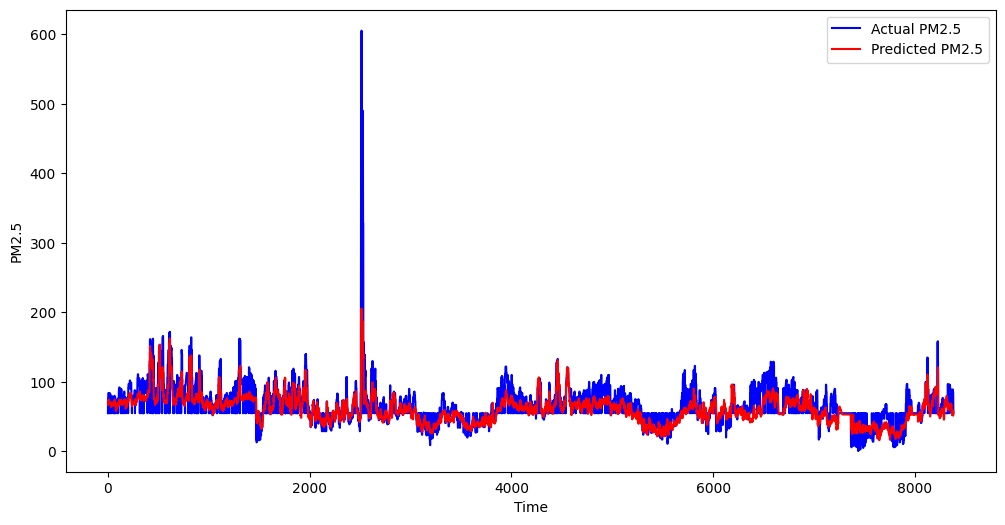

In [ ]:
# Generate predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 0], label="Actual PM2.5", color="blue")
plt.plot(y_pred_rescaled[:, 0], label="Predicted PM2.5", color="red")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")


MAE: 7.135594278599216
MSE: 277.5754369135892
RMSE: 16.66059533490893
R2 Score: -8.089326997795932e+24


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1

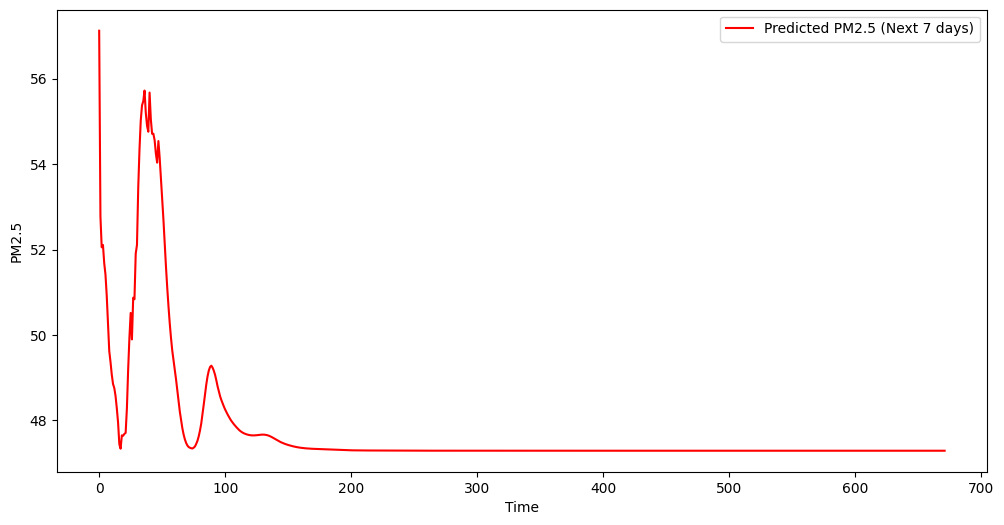

In [ ]:
future_steps = 7 * 96  # 7 days * 96 time intervals (every 15 minutes)
future_predictions = []

input_seq = X_test[-1]  # Start from the last sequence in test data

for _ in range(future_steps):
    pred = model.predict(input_seq.reshape(1, SEQ_LENGTH, -1))[0]
    future_predictions.append(pred)
    input_seq = np.vstack([input_seq[1:], pred])

# Convert predictions back to original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_predictions_rescaled[:, 0], label="Predicted PM2.5 (Next 7 days)", color="red")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [ ]:
from flask import Flask, request, jsonify
import numpy as np
import tensorflow as tf
import joblib
import datetime

app = Flask(__name__)

# Load trained model & scaler
model = tf.keras.models.load_model("bilstm_model (1).h5")
scaler = joblib.load("scaler.pkl")

SEQ_LENGTH = 48  # Sequence length used during training

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    date_input = data.get("date")

    try:
        date_input = datetime.datetime.strptime(date_input, "%Y-%m-%d")
    except:
        return jsonify({"error": "Invalid date format. Use YYYY-MM-DD"})

    # Predict for 96 future time steps (15-minute intervals for 24 hours)
    future_steps = 96
    future_predictions = []
    input_seq = X_test[-1]  # Start with the last known sequence

    for _ in range(future_steps):
        pred = model.predict(input_seq.reshape(1, SEQ_LENGTH, -1))[0]
        future_predictions.append(pred)
        input_seq = np.vstack([input_seq[1:], pred])

    # Rescale predictions back to original values
    future_predictions_rescaled = scaler.inverse_transform(future_predictions)

    predictions_list = []
    for i in range(future_steps):
        time_offset = date_input + datetime.timedelta(minutes=15 * i)
        temp = future_predictions_rescaled[i, -5]
        pm25 = future_predictions_rescaled[i, 0]
        rain = future_predictions_rescaled[i, -2]

        # Your original logic for weather conditions
        weather_condition = "Sunny" if temp > 30 else ("Mild Sunny" if temp > 20 else "Cold")
        if rain > 0:
            weather_condition = "Rainy"

        pm25_status = "Good" if pm25 < 50 else "Unhealthy"

        predictions_list.append({
            "timestamp": time_offset.strftime("%Y-%m-%d %H:%M"),
            "temperature": round(temp, 2),
            "weather": weather_condition,
            "pm2.5": round(pm25, 2),
            "pm2.5_status": pm25_status
        })

    return jsonify({
        "date": date_input.strftime("%Y-%m-%d"),
        "predictions": predictions_list
    })

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
import numpy as np
import tensorflow as tf
import joblib
import datetime

# Load trained model & scaler
model = tf.keras.models.load_model("bilstm_model (1).h5")
scaler = joblib.load("scaler.pkl")

SEQ_LENGTH = 48  # Sequence length used during training

# Get user input for date
date_input = input("Enter date (YYYY-MM-DD): ")
try:
    date_input = datetime.datetime.strptime(date_input, "%Y-%m-%d")
except ValueError:
    print("Invalid date format. Use YYYY-MM-DD")
    exit()

# Predict for 96 future time steps (15-minute intervals for 24 hours)
future_steps = 96
future_predictions = []
input_seq = X_test[-1]  # Start with the last known sequence

for _ in range(future_steps):
    pred = model.predict(input_seq.reshape(1, SEQ_LENGTH, -1))[0]
    future_predictions.append(pred)
    input_seq = np.vstack([input_seq[1:], pred])

# Rescale predictions back to original values
future_predictions_rescaled = scaler.inverse_transform(future_predictions)

# Display predictions
print(f"Predictions for {date_input.strftime('%Y-%m-%d')}:\n")
for i in range(future_steps):
    time_offset = date_input + datetime.timedelta(minutes=15 * i)
    temp = future_predictions_rescaled[i, -5]
    pm25 = future_predictions_rescaled[i, 0]
    rain = future_predictions_rescaled[i, -2]

    weather_condition = "Sunny" if temp > 30 else ("Mild Sunny" if temp > 20 else "Cold")
    if rain  < 2:
        weather_condition = "Rainy"

    pm25_status = "Good" if pm25 < 50 else "Unhealthy"

    print(f"{time_offset.strftime('%Y-%m-%d %H:%M')} | Temp: {round(temp, 2)}°C | Weather: {weather_condition} | PM2.5: {round(pm25, 2)} ({pm25_status})")


Enter date (YYYY-MM-DD): 2024-12-12
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1063/1063 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 7.4549e-04
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 3.0052e-04
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 2.4955e-04
Epoch 4/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 2.1007e-04
Epoch 5/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 1.8983e-04


💾 Model saved as: lstm_pm25_model.h5
📂 Loaded model for evaluation: lstm_pm25_model.h5

📊 **Evaluation Metrics**
MAE: 0.0110, MSE: 0.0003, RMSE: 0.0161, R²: 0.8417
📂 Loaded model from lstm_pm25_model.h5
✅ Forecast saved as PM25_forecast_15_days.csv


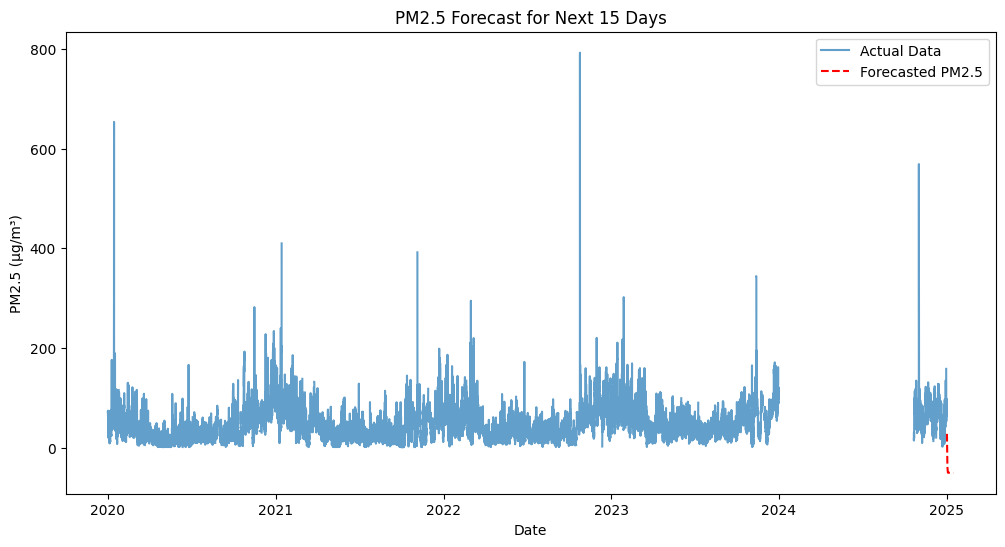

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Function to Resample Data to Hourly
def resample_to_hourly(input_file, output_file):
    df = pd.read_csv(input_file, parse_dates=["Timestamp"], infer_datetime_format=True)
    df.set_index("Timestamp", inplace=True)

    # Resample to hourly mean
    df_hourly = df.resample("1H").mean()

    # Reset index
    df_hourly.reset_index(inplace=True)

    # Save as Parquet for fast loading
    output_parquet = output_file.replace('.csv', '.parquet')
    df_hourly.to_parquet(output_parquet, index=False)

    # Save CSV copy before renaming
    df_hourly.to_csv(output_file.replace('.csv', '_backup.csv'), index=False)

    print(f"✅ Resampled dataset saved to: {output_parquet} and CSV backup saved.")

# ✅ Function to Prepare LSTM Data
def prepare_lstm_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# ✅ Function to Train & Save LSTM Model
def train_lstm_and_forecast(df, column, model_file="lstm_pm25_model.h5", n_steps=24, epochs=5):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[column]].dropna())

    # Prepare sequences
    X, y = prepare_lstm_data(scaled_data, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # LSTM Model
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train Model
    model.fit(X, y, epochs=epochs, verbose=1)

    # Save the trained model
    model.save(model_file)
    print(f"💾 Model saved as: {model_file}")

    return model, scaler

# ✅ Function to Load Model & Predict Next 15 Days (Each Row = 24 Hours)
def load_and_forecast(df, column, model_file="lstm_pm25_model.h5", n_steps=24, forecast_days=15):
    # Load Model
    model = load_model(model_file, compile=False)
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(f"📂 Loaded model from {model_file}")

    # Scaling Data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[column]].dropna())

    # Forecast Next 15 Days (Each Row = 24 Hours)
    forecast_hours = forecast_days * 24
    predictions = []
    input_seq = scaled_data[-n_steps:].reshape(1, n_steps, 1)

    for _ in range(forecast_hours):
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0][0])
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1, 0] = pred[0][0]

    # Convert Predictions Back to Original Scale
    predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Reshape into 15 Days (Each Row = 24-Hour Predictions)
    time_labels = [f"{i:02d}" for i in range(24)]  # "00, 01, ..., 23"
    forecast_df = pd.DataFrame(predicted_values.reshape(forecast_days, 24), columns=time_labels)

    # Add Date Column
    start_date = df['Timestamp'].iloc[-1] + pd.Timedelta(hours=1)
    forecast_df.insert(0, "Date", pd.date_range(start=start_date, periods=forecast_days, freq="D"))

    return forecast_df

# ✅ Function to Evaluate Model
def evaluate_model(df, column, model_file="lstm_pm25_model.h5", n_steps=24):
    model = load_model(model_file, compile=False)
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(f"📂 Loaded model for evaluation: {model_file}")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[column]].dropna())

    X, y = prepare_lstm_data(scaled_data, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    y_pred = model.predict(X, verbose=0)

    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    print(f"\n📊 **Evaluation Metrics**")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ✅ Function to Plot Actual vs Forecasted Data
def plot_predictions(df, forecast_df, column):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Timestamp'], df[column], label='Actual Data', alpha=0.7)

    # Generate future timestamps
    future_dates = forecast_df["Date"]
    predicted_means = forecast_df.iloc[:, 1:].mean(axis=1)

    plt.plot(future_dates, predicted_means, label='Forecasted PM2.5', linestyle='dashed', color='red')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.title(f"PM2.5 Forecast for Next 15 Days")
    plt.show()

# ✅ Main Execution
input_file = "/content/Merged_Data_sets_2020_2024.csv"
output_file = "/content/Merged_Data_sets_2020_2024hours.csv"
parquet_file = output_file.replace('.csv', '.parquet')

# Ensure Resampled Data Exists
if not os.path.exists(parquet_file):
    print("🔄 Resampling data to hourly...")
    resample_to_hourly(input_file, output_file)

# Load Data
df_hourly = pd.read_parquet(parquet_file)
df_hourly["Timestamp"] = pd.to_datetime(df_hourly["Timestamp"])

# Train & Save Model
model, scaler = train_lstm_and_forecast(df_hourly, "PM2.5 (µg/m³)")

# Evaluate Model
evaluate_model(df_hourly, "PM2.5 (µg/m³)")

# Forecast Next 15 Days Using Saved Model
forecast_df = load_and_forecast(df_hourly, "PM2.5 (µg/m³)")

# Save Forecast
forecast_df.to_csv("PM25_forecast_15_days.csv", index=False)
print("✅ Forecast saved as PM25_forecast_15_days.csv")

# Plot Results
plot_predictions(df_hourly, forecast_df, "PM2.5 (µg/m³)")


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1063/1063 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 6.2138e-04
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 3.3668e-04
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 2.2158e-04
Epoch 4/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - loss: 2.1139e-04
Epoch 5/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 2.1836e-04


✅ Model saved as lstm_pm25_model.h5
✅ Forecast saved as PM25_forecast_15_days.csv


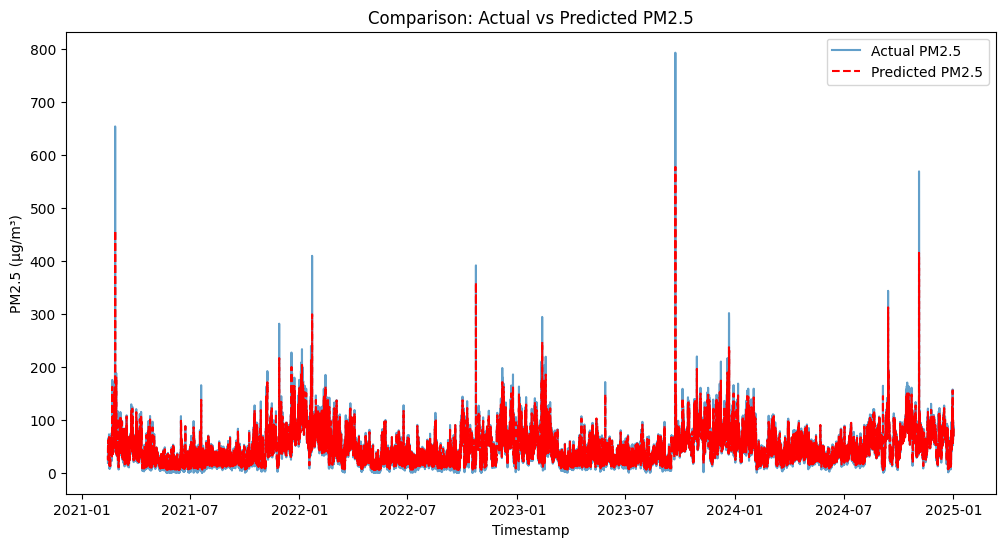

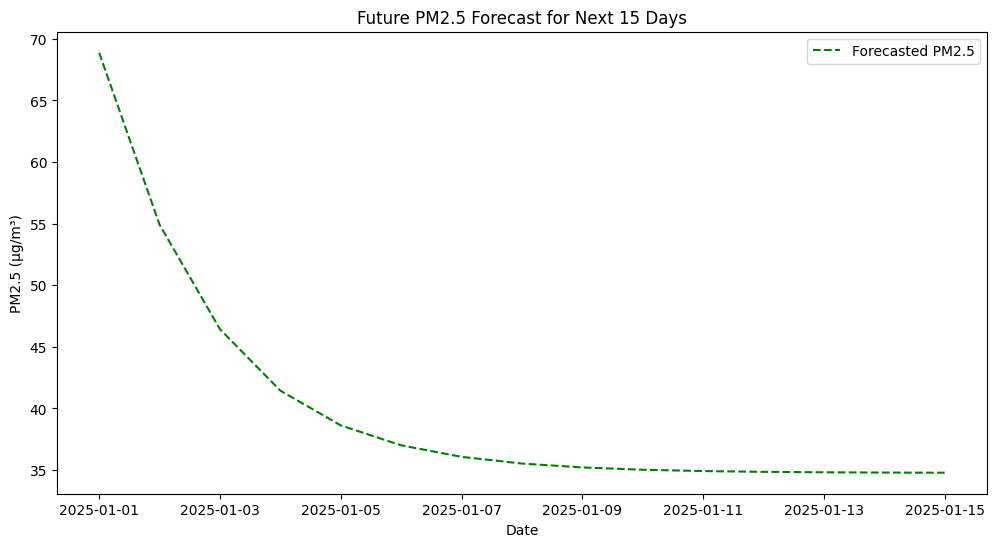

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

# Function to Resample CSV to Hourly and Save as Parquet and CSV
def resample_to_hourly(input_file, output_file):
    df = pd.read_csv(input_file, parse_dates=["Timestamp"], infer_datetime_format=True)
    df.set_index("Timestamp", inplace=True)
    df_hourly = df.resample("1H").mean()
    df_hourly.reset_index(inplace=True)

    # Save both CSV and Parquet
    df_hourly.to_parquet(output_file.replace('.csv', '.parquet'), index=False)
    df_hourly.to_csv(output_file, index=False)
    print(f"✅ Resampled dataset saved as CSV and Parquet: {output_file}")
    return df_hourly

# Function to Prepare Data for LSTM
def prepare_lstm_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Function to Train & Save LSTM Model
def train_lstm(df, column, n_steps=24, epochs=5, model_file="lstm_pm25_model.h5"):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[column]].dropna())
    X, y = prepare_lstm_data(scaled_data, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=1)

    # Save Model
    model.save(model_file)
    print(f"✅ Model saved as {model_file}")
    return model, scaler

# Function to Load Model & Forecast Next 15 Days
def forecast_future(df, column, n_steps=24, forecast_days=15, model_file="lstm_pm25_model.h5"):
    model = load_model(model_file, compile=False)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[column]].dropna())

    forecast_hours = forecast_days * 24
    predictions = []
    input_seq = scaled_data[-n_steps:].reshape(1, n_steps, 1)

    for _ in range(forecast_hours):
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0][0])
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1, 0] = pred[0][0]

    predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Reshape Predictions into 15 Days (Each Row = 24 Hours)
    forecast_df = pd.DataFrame(predicted_values.reshape(forecast_days, 24),
                               columns=[f"{i:02d}" for i in range(24)])
    forecast_df.insert(0, "Date", pd.date_range(start=df['Timestamp'].iloc[-1] + pd.Timedelta(hours=1),
                                                 periods=forecast_days, freq="D"))
    forecast_df.to_csv("PM25_forecast_15_days.csv", index=False)
    print("✅ Forecast saved as PM25_forecast_15_days.csv")
    return forecast_df

# Function to Plot Actual vs Predicted and Future Forecast
def plot_predictions(df, forecast_df, column, model_file="lstm_pm25_model.h5", n_steps=24):
    model = load_model(model_file, compile=False)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[column]].dropna())
    X, y = prepare_lstm_data(scaled_data, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y_pred = model.predict(X, verbose=0)

    y_actual = scaler.inverse_transform(y.reshape(-1, 1))
    y_predicted = scaler.inverse_transform(y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(df["Timestamp"][-len(y_actual):], y_actual, label="Actual PM2.5", alpha=0.7)
    plt.plot(df["Timestamp"][-len(y_predicted):], y_predicted, label="Predicted PM2.5", linestyle="dashed", color="red")
    plt.xlabel("Timestamp")
    plt.ylabel(column)
    plt.legend()
    plt.title("Comparison: Actual vs Predicted PM2.5")
    plt.show()

    plt.figure(figsize=(12, 6))
    future_dates = forecast_df["Date"]
    predicted_means = forecast_df.iloc[:, 1:].mean(axis=1)
    plt.plot(future_dates, predicted_means, label="Forecasted PM2.5", linestyle="dashed", color="green")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.title("Future PM2.5 Forecast for Next 15 Days")
    plt.show()

# Main Execution
input_file = "Merged_Data_sets_2020_2024.csv"
output_file = "Merged_Data_sets_2020_2024hours.csv"
parquet_file = output_file.replace('.csv', '.parquet')

# Ensure resampled data exists
if not os.path.exists(parquet_file):
    df_hourly = resample_to_hourly(input_file, output_file)
else:
    df_hourly = pd.read_parquet(parquet_file)

df_hourly["Timestamp"] = pd.to_datetime(df_hourly["Timestamp"])

# Train & Save Model
model, scaler = train_lstm(df_hourly, "PM2.5 (µg/m³)")

# Load Model & Forecast Future Values
forecast_df = forecast_future(df_hourly, "PM2.5 (µg/m³)")

# Plot Results
plot_predictions(df_hourly, forecast_df, "PM2.5 (µg/m³)")
